<a href="https://colab.research.google.com/github/miloszpiechota/AI-Systems/blob/main/ASL_Alphabet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /kaggle/input/asl-alphabet
Number of pictures: 78300
Number of different labels: 29
Labels: ['X' 'T' 'space' 'Y' 'M' 'G' 'C' 'F' 'W' 'K' 'P' 'A' 'J' 'Q' 'V' 'S' 'L'
 'B' 'H' 'Z' 'R' 'D' 'O' 'del' 'E' 'nothing' 'U' 'N' 'I']


KeyError: 14

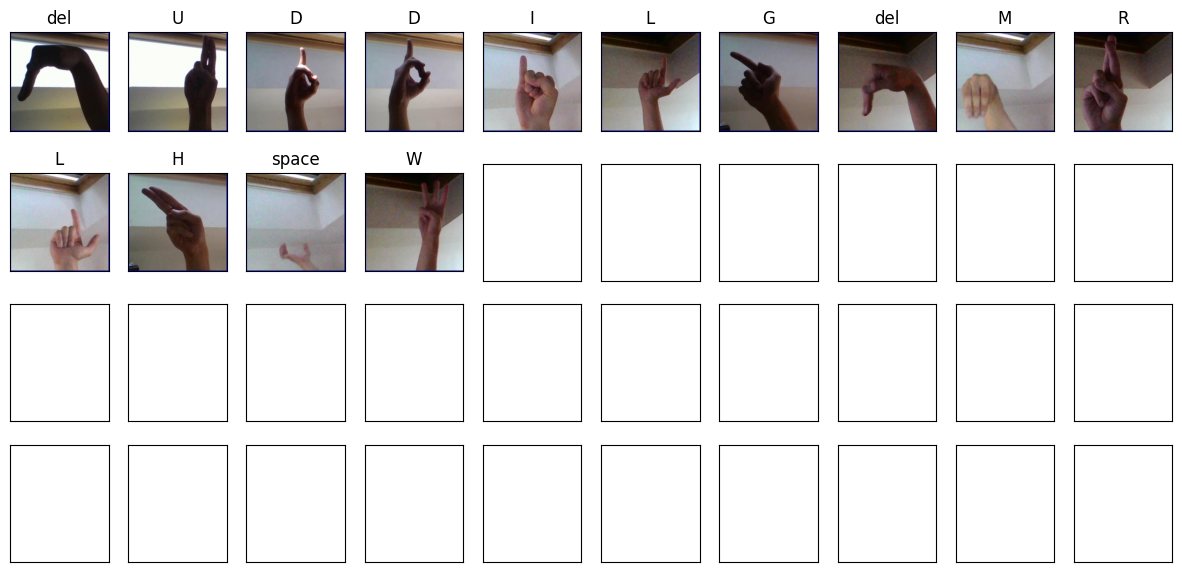

In [10]:
# === Import bibliotek ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, classification_report

# === (Colab only) Połączenie z Google Drive ===
# from google.colab import drive
# drive.mount('/content/gdrive')

# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle datasets download -d grassknoted/asl-alphabet
# !unzip \*.zip && rm *.zip

# === (Kaggle only) Pobieranie przez kagglehub ===
import kagglehub
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print("Path to dataset files:", path)

# === Funkcja do tworzenia DataFrame ===
def imgPaths(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

# === Wczytanie obrazów i utworzenie DataFrame ===
train_image_dir = Path('/kaggle/input/asl-alphabet/asl_alphabet_train')
train_filepaths = list(train_image_dir.glob(r'**/*.jpg'))
train_df = imgPaths(train_filepaths)

# Tymczasowo wykorzystujemy część danych jako test (bo zbiór nie ma osobnego testu)
train_df, test_df = train_test_split(train_df, test_size=0.1, stratify=train_df['Label'], random_state=42)

# === Informacje o danych ===
print(f'Number of pictures: {train_df.shape[0]}')
print(f'Number of different labels: {len(train_df.Label.unique())}')
print(f'Labels: {train_df.Label.unique()}')

# === Przykładowe obrazy ===
df_unique = train_df.drop_duplicates(subset=["Label"]).reset_index()
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i])
plt.tight_layout(pad=.5)
plt.show()

# === Generatory obrazów ===
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    fill_mode='nearest',
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2, 1.0]
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# === Załaduj MobileNetV2 ===
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrainedModel.trainable = False

# === Zbuduj model ===
inputs = pretrainedModel.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Trenowanie ===
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

# === Zapisz model ===
model.save('model_large_asl_mobilenet-v1.h5')

# === Ewaluacja ===
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# === Predykcje ===
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

print(f'The first 5 predictions: {pred[:5]}')

# === Dokładność i raport ===
y_test = list(test_df.Label)
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')
print(classification_report(y_test, pred))

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

max_images = min(len(train_df), 40)  # zabezpieczenie na wypadek mniejszej liczby obrazów

for i, ax in enumerate(axes.flat[:max_images]):
    ax.imshow(plt.imread(train_df.Filepath.iloc[i]))
    ax.set_title(train_df.Label.iloc[i])

# Układ i wyświetlenie
plt.tight_layout(pad=0.5)
plt.show()



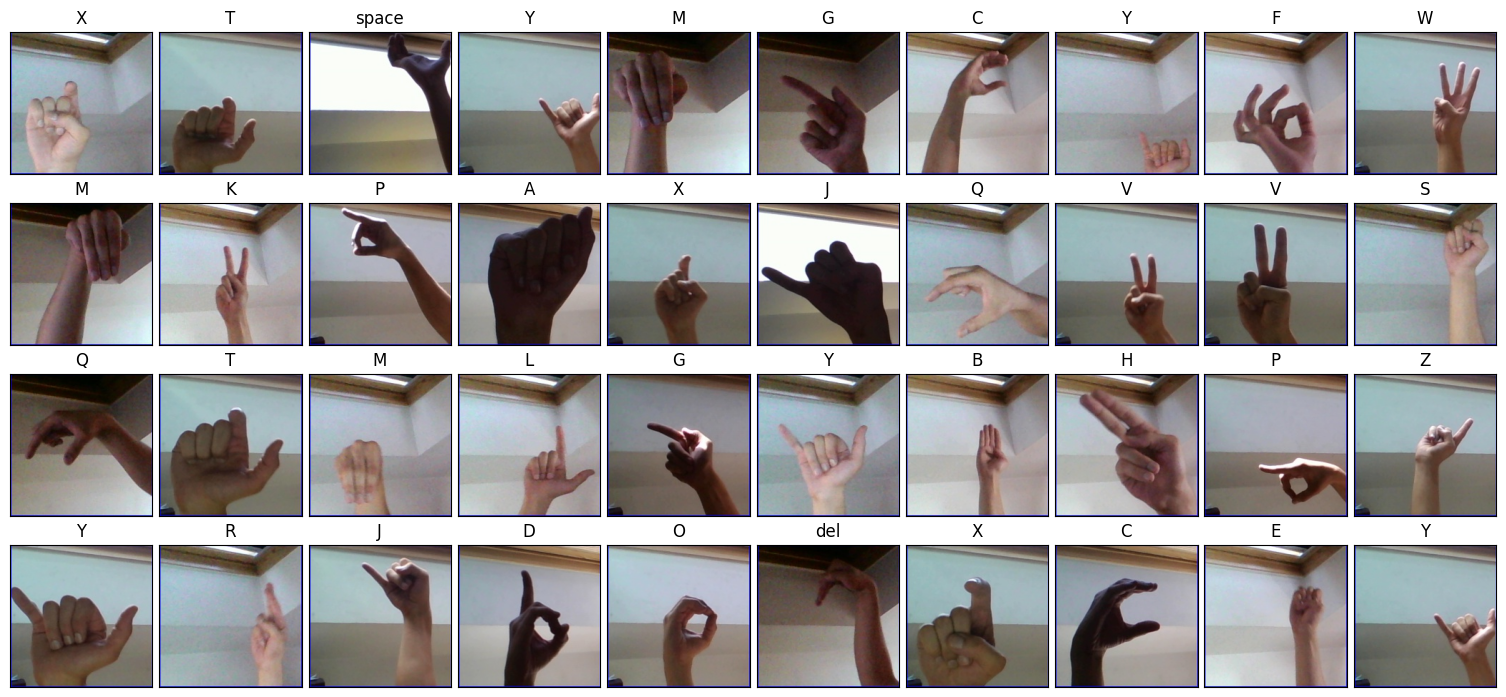

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

max_images = min(len(train_df), 40)  # zabezpieczenie na wypadek mniejszej liczby obrazów

for i, ax in enumerate(axes.flat[:max_images]):
    ax.imshow(plt.imread(train_df.Filepath.iloc[i]))
    ax.set_title(train_df.Label.iloc[i])

# Układ i wyświetlenie
plt.tight_layout(pad=0.5)
plt.show()


In [1]:
# === Import bibliotek ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub

# === Pobranie danych przez kagglehub ===
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print("Path to dataset files:", path)

# === Funkcja do tworzenia DataFrame ===
def imgPaths(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

# === Wczytanie i przygotowanie danych ===
train_image_dir = Path('/kaggle/input/asl-alphabet/asl_alphabet_train')
filepaths = list(train_image_dir.glob('**/*.jpg'))
df = imgPaths(filepaths)

# === Zmniejszenie liczby danych (np. 500 na klasę) ===
df = df.groupby('Label').apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)

# Podział na zbiór treningowy i testowy
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['Label'], random_state=42)

# === Parametry ===
target_size = (96, 96)
batch_size = 64

# === Generatory obrazów ===
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# === Model – MobileNetV2 (96x96) ===
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input
x = tf.keras.layers.Dense(64, activation='relu')(pretrainedModel.output)
outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Trenowanie modelu ===
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

# === Zapis modelu ===
model.save('model_fast_asl_mobilenetv2.h5')

# === Ewaluacja ===
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# === Predykcje ===
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Mapowanie etykiet
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

print(f'The first 5 predictions: {pred[:5]}')

# === Ocena jakości ===
y_test = list(test_df.Label)
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')
print(classification_report(y_test, pred))

# === Wizualizacja wyników ===
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20, 12), subplot_kw={'xticks': [], 'yticks': []})
max_images = min(len(test_df), 35)
for i, ax in enumerate(axes.flat[:max_images]):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPred: {pred[i].split('_')[0]}", fontsize=15)
plt.tight_layout()
plt.show()


Path to dataset files: /kaggle/input/asl-alphabet


<ipython-input-1-7c2acac03fa9>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Label').apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)


Found 10440 validated image filenames belonging to 29 classes.
Found 2610 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.4157 - loss: 2.1588 - val_accuracy: 0.8510 - val_loss: 0.5233
Epoch 2/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 162s 816ms/step - accuracy: 0.8851 - loss: 0.4240 - val_accuracy: 0.9027 - val_loss: 0.3271
Epoch 3/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 141s 860ms/step - accuracy: 0.9278 - loss: 0.2600 - val_accuracy: 0.9257 - val_loss: 0.2537


Test Loss: 0.26856
Test Accuracy: 92.14%
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 560ms/step
The first 5 predictions: ['U', 'D', 'Z', 'M', 'R']
Accuracy on the test set: 92.14%
              precision    recall  f1-score   support

           A       0.86      0.86      0.86        50
           B       0.94      0.98      0.96        50
           C       0.98      0.98      0.98        50
           D       1.00      0.94      0.97        50
           E       0.80      0.80      0.80        50
           F       1.00      0.88      0.94        50
           G       0.98      0.92      0.95        50
           H       0.96      0.98      0.97        50
           I       0.83      0.98      0.90        50
           J       1.00      0.98      0.99        50
           K       0.80      0.98      0.88        50
           L       1.00      1.00      1.00        50
           M       0.96      1.00      0.98        50
           N       1.00      0.94      0.97        50
           O       0.9